# Parameter Inference and Calibration: Linking UER to GDP

View target demand as input to the model (instead of a stylized sinusoidal business cycle). 

I see two possible options:
1. GDP growth in line with Okun's Law specifically for unemployment - a 1% change in GDP = 0.03-0.05% change in UER
2. Growth in target demand


In [1]:
# Import packages
from abm_funs import *
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import tempfile
import matplotlib.image as mpimg
import pyabc
from scipy.stats import pearsonr
from pyabc.visualization import plot_kde_matrix, plot_kde_1d
import math as math
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
from IPython.display import display
from PIL import Image
from pstats import SortKey
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from collate_macro_vars import *
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

Function import successful


In [2]:
realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())

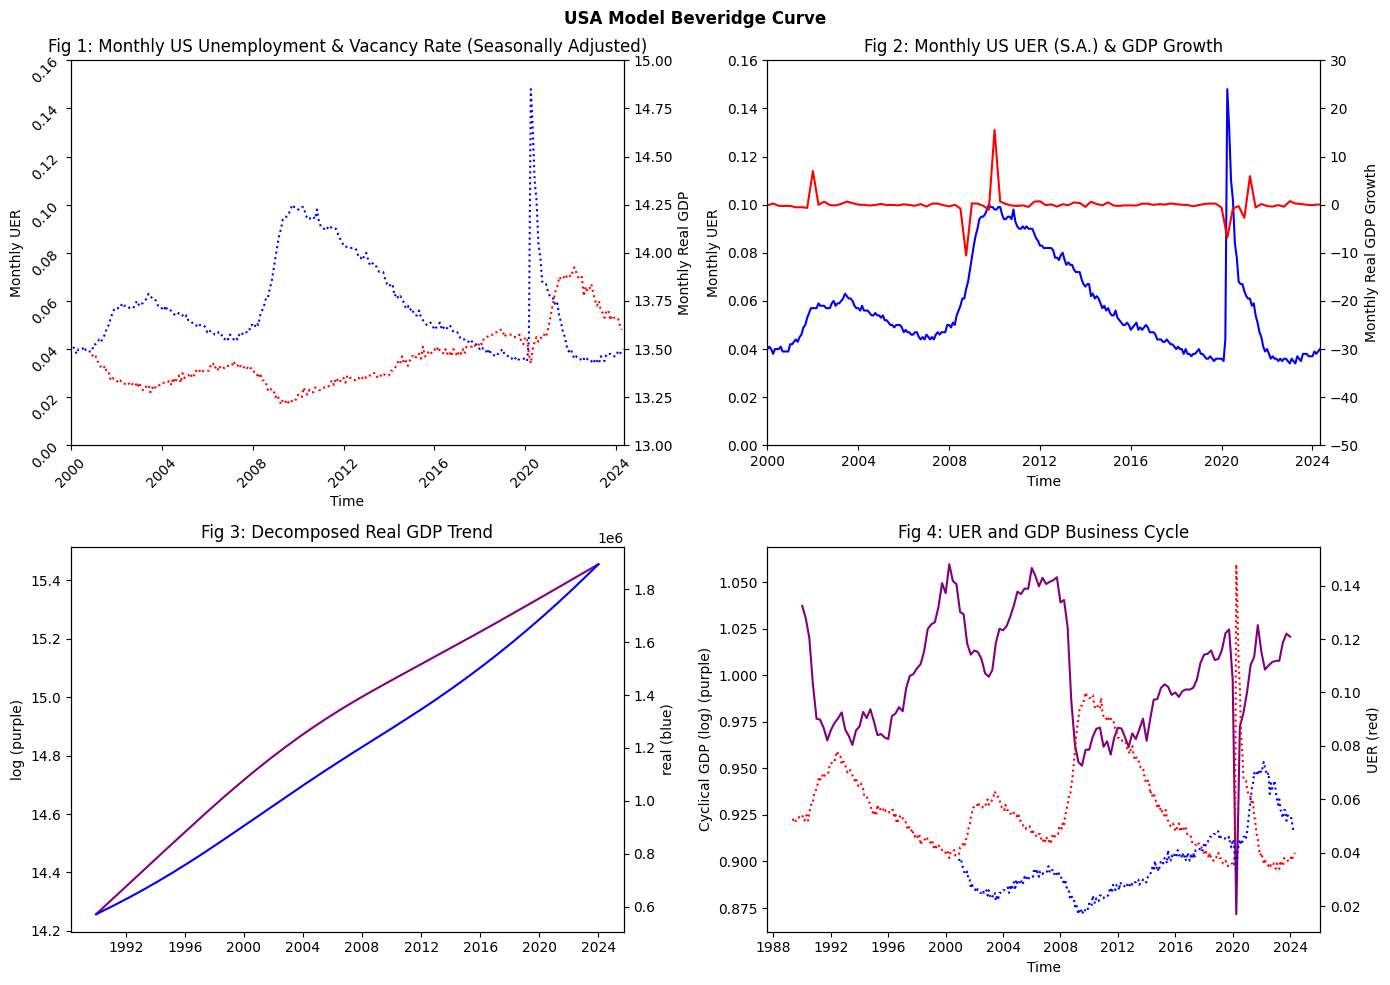

In [3]:

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# Unpack the axes into variables for easier access
(ax1, ax2), (ax3, ax4) = axes


ax1.plot(macro_observations['DATE'], macro_observations['UER'], color = "blue", linestyle = "dotted")
ax1.plot(macro_observations['DATE'], macro_observations['VACRATE'], color = "red", linestyle = "dotted")
# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax1.set_title("Fig 1: Monthly US Unemployment & Vacancy Rate (Seasonally Adjusted)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Monthly UER")
ax1_twin = ax1.twinx()
ax1_twin.set_ylim([13, 15])
ax1.tick_params(rotation=45)
ax1.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])
ax1.set_ylim([0, 0.16])
ax1_twin.set_ylabel("Monthly Real GDP")

ax2.plot(macro_observations['DATE'], macro_observations['UER'], color = "blue")
ax2_twin = ax2.twinx()
ax2_twin.plot(gdp_growth['DATE'], gdp_growth['GDP_GROWTH'].pct_change(periods = 1), label = "Real GDP", color = "red")

# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_title("Fig 2: Monthly US UER (S.A.) & GDP Growth")
ax2.set_xlabel("Time")
ax2.set_ylabel("Monthly UER")
ax2.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])
ax2.set_ylim([0, 0.16])
ax2_twin.set_ylim([-50, 30])
ax2_twin.set_ylabel("Monthly Real GDP Growth")

ax3.plot(realgdp['DATE'], realgdp['log_Trend'], color = "purple")
ax3_twin = ax3.twinx()
ax3_twin.plot(realgdp['DATE'], realgdp['Trend'], color = "blue")
ax3.set_title("Fig 3: Decomposed Real GDP Trend")
ax3.set_ylabel("log (purple)")
ax3_twin.set_ylabel("real (blue)")

ax4.plot(realgdp['DATE'], realgdp['log_Cycle'], color = "purple")
ax4_twin = ax4.twinx()
ax4_twin.plot(macro_observations['DATE'], macro_observations['UER'], color = "red", linestyle = "dotted")
ax4_twin.plot(macro_observations['DATE'], macro_observations['VACRATE'], color = "blue", linestyle = "dotted")
ax4.set_title("Fig 4: Decomposed Real GDP Cycle")
ax4.set_ylabel("Cyclical GDP (log) (purple)")
#ax4.set_xlim([datetime.date(2000,1,1), datetime.date(2019,10,1)])

ax4_twin.set_ylabel("UER (red)")

# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax4.set_title("Fig 4: UER and GDP Business Cycle")
ax4.set_xlabel("Time")
#ax4.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


#plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
plt.show()
plt.close()


In [4]:
t = np.arange(0,len(realgdp['DATE']),1)
bus_cycle = bus_cycle_demand(0.5, t, 1, 30)

plt.plot(realgdp['DATE'], bus_cycle, label = "Stylised Sinusoidal Business Cycle")
plt.plot(realgdp['DATE'], realgdp['scaled_log_Cycle'], label = "GDP Cycle (Normalised)")
plt.plot(realgdp_no_covid['DATE'], realgdp_no_covid['scaled_log_Cycle'], label = "GDP Cycle (Normalised - excl. Covid)")
#plt.plot(np.arange(0,78,1), gdp_dat, label = "Calib Period" )
plt.legend(fontsize=7)
plt.ylim([-0.2,1.2])
plt.title("Various business cycle representations")

plt.show()


NameError: name 'bus_cycle_demand' is not defined

In [ ]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################

# Set dates to which you wish to calibrate the model
# pre-Covid: 
# Full time series: "2024-5-1"
calib_date = ["2000-12-01", "2019-05-01"]
gdp_dat_pd = realgdp_no_covid[(realgdp_no_covid['DATE'] >= calib_date[0]) & (realgdp_no_covid['DATE'] <= calib_date[1])]
gdp_dat = np.array(gdp_dat_pd['scaled_log_Cycle'])# *0.06

# Set preliminary parameters for delta_u, delta_v, and gamma 
# - these reproduce nice Beveridge curves but were arrived at non-systematically
del_u = 0.01
del_v = 0.005
behav_spec = False
gamma_u = gamma_v = gamma = 0.02
#bus_amp = 0.06

A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/100000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)

params = {'mod_data': mod_data, # mod_data: occupation-level input data (ie. employment/uneployment levels, wages, gender ratio, etc.).
     'net_temp': net_temp, # net_temp: occupational network
     'vacs': vacs, # list of available vacancies in the economy
     'behav_spec': behav_spec, # whether or not to enable behavioural element or not (boolean value)
     'time_steps': len(gdp_dat), # number of time steps to iterate the model - for now always exclude ~50 time steps for the model to reach a steady-state
     'd_u': del_u, # del_u: spontaneous separation rate
     'd_v': del_v, # del_v: spontaneous vacancy rate
     'gamma': gamma, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     'delay': 0,
     'gdp_data': gdp_dat,
     'simple_res': True} # d


In [ ]:
####################
# Model Run ########
####################
def run_single_local(mod_data = mod_data, 
               net_temp = net_temp, 
               vacs = vacs, 
               behav_spec = behav_spec, 
               time_steps = len(gdp_dat), # set equal to length of gdp_data
               d_u = del_u, 
               d_v = del_v,
               gamma = gamma,
               delay = 0,
               gdp_data = gdp_dat,
               simple_res = True):
    #net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy())
    #behav_spec = False
    #time_steps = 30
    #gamma = 0.1
    #d_v = 0.009
    
    """ Runs the model once
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    # Initialise deepcopy occupational mobility network
    record = [np.sum(np.concatenate((np.zeros((464, 1)), 
                                    mod_data['employment'].to_numpy(), 
                                    mod_data['unemployment'].to_numpy(), 
                                    mod_data['employment'].to_numpy() + mod_data['unemployment'].to_numpy(),
                                    mod_data['vacancies'].to_numpy(), 
                                    np.zeros((464, 1)),
                                    mod_data['demand_target'].to_numpy()), axis = 1), 
                                    axis = 0)]
    
    #print(parameter['vacs'])
    vacs_temp = deepcopy(vacs)
    net = deepcopy(net_temp)
    for t in range(time_steps):
        # Ensure number of workers in economy has not changed
        #tic = time.process_time()
        for occ in net:
            ### APPLICATIONS
            # Questions to verify:
            # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # - CAN be rejected and apply in the same time step - no protected attribute
            # isolate list of vacancies in economy that are relevant to the occupation
            # - avoids selecting in each search_and_apply application
            r_vacs = [vac for vac in vacs_temp if occ.list_of_neigh_bool[vac.occupation_id]]                
            for u in occ.list_of_unemployed:
                u.search_and_apply(net, r_vacs, behav_spec)

            ### SEPARATIONS
            occ.separate_workers(d_u, gamma)

        ### HIRING
        # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
        # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
        # ....might be better to do this using an unordered set?
        for v_open in sorted(vacs_temp,key=lambda _: random.random()):
            # Removes any applicants that have already been hired in another vacancy
            v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
            if len(v_open.applicants) > 0:
                v_open.hire(net)
                v_open.filled = True
                #vacs.remove(v_open)
                assert(len(v_open.applicants) == 0)
            else:
                pass

        vacs_temp = [v for v in vacs_temp if not(v.filled)] 

        # Reset counters for record in time t
        empl = 0 
        unemp = 0
        n_ltue = 0
        t_demand = 0

        ### OPEN VACANCIES
        # Update vacancies after all shifts have taken place
        # Could consider making this a function of the class itself?
        for occ in net:
            # Update time_unemployed and long-term unemployed status of unemployed workers
            # Remove protected "hired" attribute of employed workers
            occ.update_workers()
            emp = len(occ.list_of_employed)
            occ.current_demand = (len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp)*(1-gdp_data[t])
            #occ.current_demand = bus_cycle_demand(len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp, t, bus_amp, bus_cycle_len)
            vac_prob = d_v + ((1 - d_v) * (gamma * max(0, occ.target_demand - occ.current_demand))) / (emp + 1)
            vacs_create = emp*int(vac_prob) + int(np.random.binomial(emp, vac_prob%1))
            for v in range(vacs_create):
                vacs_temp.append(vac(occ.occupation_id, [], occ.wage, False))

            empl += len(occ.list_of_employed) 
            unemp += len(occ.list_of_unemployed)
            n_ltue += sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed)
            t_demand += occ.target_demand

        ### UPDATE INDICATOR RECORD
        record = np.append(record, 
                               np.array([[t+1, empl, unemp, empl + unemp, len(vacs_temp), n_ltue, t_demand]]), 
                               axis = 0)


    # clean_record = pd.DataFrame(record[delay:])
    # clean_record.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
    # clean_record['UER'] = clean_record['Unemployment']/clean_record['Workers']
    # clean_record['VACRATE'] = clean_record['Vacancies']/clean_record['Target_Demand']
    #data = clean_record[['Time Step', 'UER', 'VACRATE']]
    data = {'UER': record[delay:,2]/record[delay:,3], 
            'VACRATE': record[delay:,4]/record[delay:,6]}

    #ltuer = (clean_record['LT Unemployed Persons']/clean_record['Workers']).mean(axis = 0)
    #vac_rate = (clean_record['Vacancies']/clean_record['Target_Demand']).mean(axis = 0)
    if simple_res:
        return data
    else:
        return [record], [net]



#########################################
# Wrapper for pyabc ########
#########################################
def pyabc_run_single(parameter):     
    res = run_single_local(**parameter)
    return res 


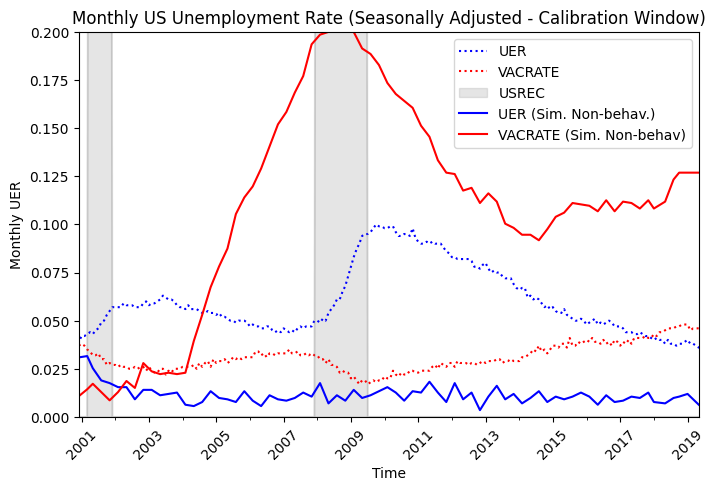

In [156]:
test_nonbehav = run_single_local(**params)
# Incorporating one set of simulated data
sim_data = pd.DataFrame(test_nonbehav)
sim_data['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data))

# sim_data_behav = pd.DataFrame(rec_behav)
# sim_data_behav['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data_behav), freq = "ME")
# sim_data_behav['FD_SIMUER'] = pd.Series(sim_data_behav['UER']).diff()
# sim_data_behav['FD_SIMVACRATE'] = pd.Series(sim_data_behav['VACRATE']).diff()

# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
plt.plot(np.arange(0, len(gdp_dat), 1), gdp_dat)
#sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Behav.)")
#sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav.)")

plt.xlim(calib_date[0], calib_date[1])
plt.ylim(0, 0.2)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted - Calibration Window)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [157]:
run = True
if run:
    # Proposed priors for d_u and d_v taken from the separations and 
    # job openings rates modelled in the first few plots of this notebook
    prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.0001, 0.1),
                            d_v = pyabc.RV("uniform", 0.0001, 0.1),
                            gamma = pyabc.RV("uniform", 0.00001, 0.1))
    
    
    def harmonise_length(x, y):
        """
        GDP data used to calibrate has lower periodicity than the UER and VACRATE used for calibration. The following linearly interpolates the simulated output to match the frequency of the UER and Vacancy Rate data
        Harmonises the length of the time series to compare to each other. 
         
        Args:
            x (dict): Simulated data with keys "UER" and "VACRATE".
            y (dict): Real-world data with keys "UER" and "VACRATE".
        
        Returns:
            expanded_format: x expanded via linear interpolation - now of same length as y (observed time series of UER and vacancy rate)
        """
        expanded_format = pd.DataFrame({
            col: np.interp(
                np.linspace(0, len(x[col]) - 1, len(y[col])),
                np.linspace(0, len(x[col]) - 1, len(x[col])),
                x[col]
                )
                for col in x.keys()
                })
        return expanded_format

    # distance function jointly minimises distance between simulated 
    # mean of UER and vacancy rates to real-world UER and vacancy rates
    # Now also matches the shape/oscillation of each variable as an attempt to better match the vacancy rate
    def distance_weighted(x, y, weight_shape=0.3, weight_mean=0.7):
        """
        Weighted distance function combining mean difference and correlation.

        Args:
            x (dict): Simulated data with keys "UER" and "VACRATE".
            y (dict): Real-world data with keys "UER" and "VACRATE".
            weight_shape (float): Weight for shape matching (correlation).
            weight_mean (float): Weight for mean matching (SSE).

        Returns:
            dist (float): Combined distance measure (UER and VACRATE).
        """

        x_ = harmonise_length(x, y)
        # Calculate sum of squared errors (SSE) for UER and VACRATE
        uer_sse = np.sum(((x_["UER"] - y["UER"]) / np.mean(y["UER"]))**2)
        vacrate_sse = np.sum(((x_["VACRATE"] - y["VACRATE"]) / np.mean(y["VACRATE"]))**2)
        
        # Correlation between simulated and real-world VACRATE (shape matching)
        corr_vacrate = 1 - pearsonr(x_["VACRATE"], y["VACRATE"])[0]
        
        # Correlation between simulated and real-world UER (shape matching)
        corr_uer = 1- pearsonr(x_["UER"], y["UER"])[0]
        
        # Define total distance as weighted sum of mean and shape components
        dist = weight_mean * (np.sqrt(uer_sse) + np.sqrt(vacrate_sse)) + weight_shape * (corr_vacrate + corr_uer)
        return dist

    calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs = 2)
    abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size = 50, sampler = calib_sampler)

    db_path = os.path.join(tempfile.gettempdir(), "test.db")

    # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
    observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
    #

    data = {'UER': np.array(observation['UER']),
            'VACRATE': np.array(observation['VACRATE'])}

    abc.new("sqlite:///" + db_path, data)

    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

ABC.Sampler INFO: Parallelize sampling on 2 processes.
ABC.History INFO: Start <ABCSMC id=9, start_time=2025-02-24 12:44:45>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.45374481e+02.


sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset


ABC INFO: Accepted: 50 / 110 = 4.5455e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 7.80474736e+01.
ABC INFO: Accepted: 50 / 116 = 4.3103e-01, ESS: 4.2587e+01.
ABC INFO: t: 2, eps: 6.31191275e+01.
ABC INFO: Accepted: 50 / 103 = 4.8544e-01, ESS: 3.0887e+01.
ABC INFO: t: 3, eps: 4.86189766e+01.
ABC INFO: Accepted: 50 / 95 = 5.2632e-01, ESS: 3.1558e+01.
ABC INFO: t: 4, eps: 3.92746553e+01.
ABC INFO: Accepted: 50 / 115 = 4.3478e-01, ESS: 4.4902e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=9, duration=0:05:29.861807, end_time=2025-02-24 12:50:15>


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset
sep_prob above 1 - reset


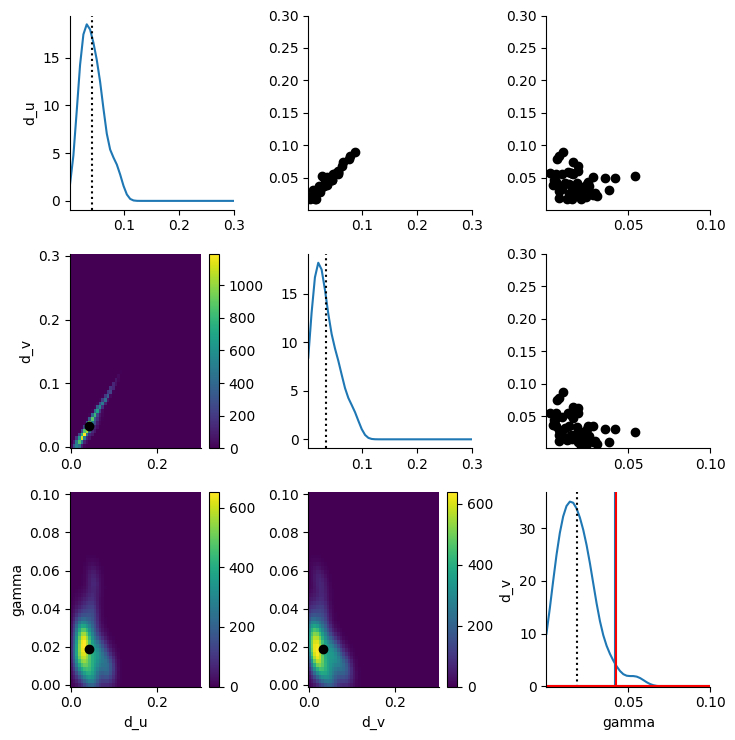

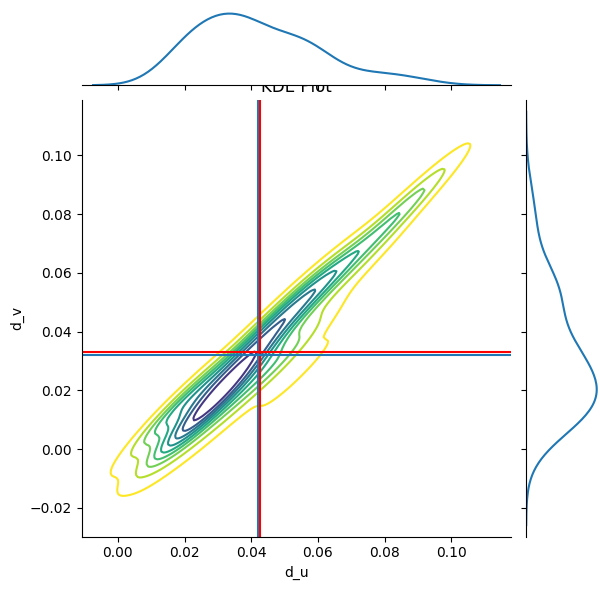

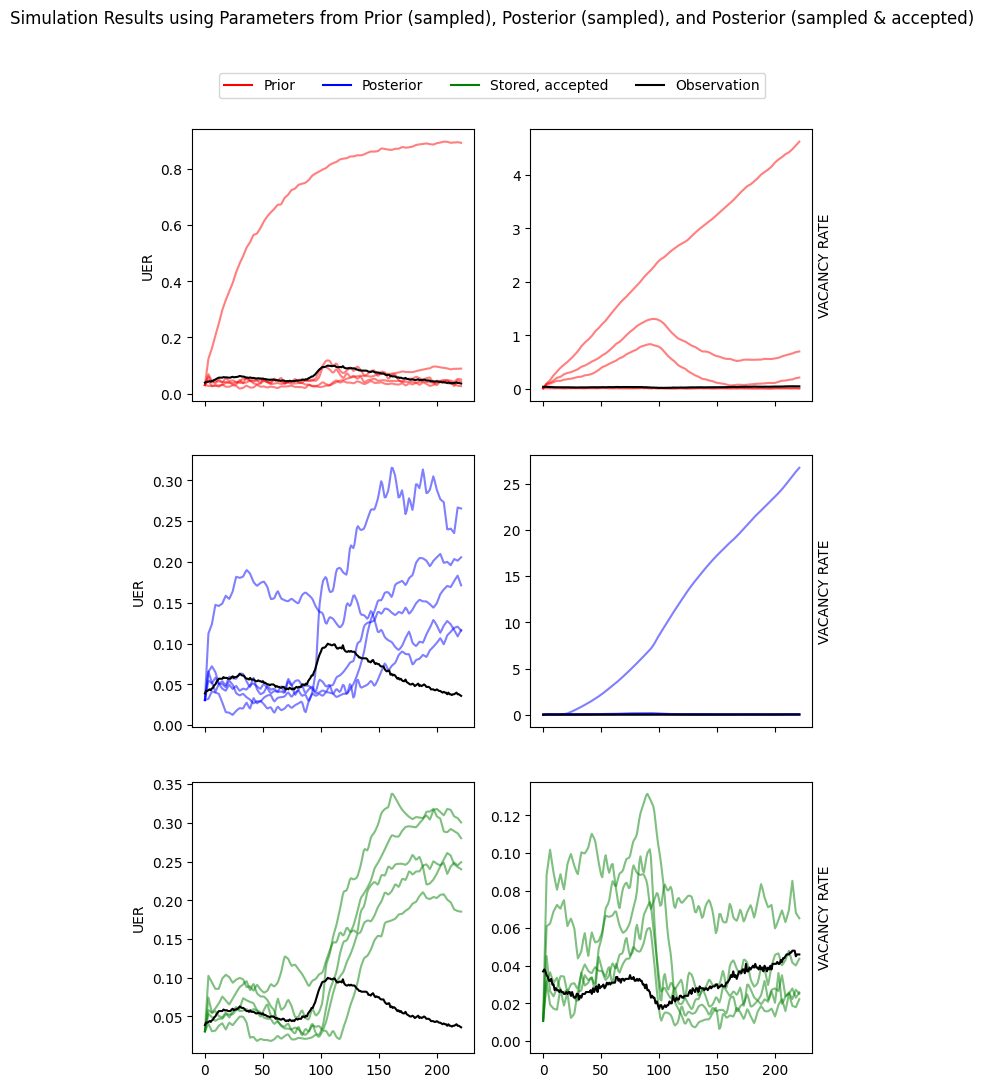

In [158]:
gt = {"d_u": jolts['SEPSRATE'].mean(axis = 0), "d_v": jolts['QUITSRATE'].mean(axis = 0), "gamma": 0.2}

df, w = history.get_distribution()
gt = {"d_u": df['d_u'].mean(axis = 0), "d_v": np.sum(df['d_v']*w), "gamma": np.sum(df['gamma']*w)}

plot_kde_matrix(
    df,
    w,
    limits={"d_u": (0.001, 0.3), "d_v": (0.001, 0.3), "gamma": (0.0001, 0.1)},
    refval=gt,
    refval_color='k',
)
# Not sure if the value to be extracted is the weighted mean of the outcome or simply the mean?
sns.kdeplot(x = "d_u", y = "d_v", data = df, weights = w, cmap = "viridis", fill = True)
plt.axvline(x = df['d_u'].mean(axis = 0))
plt.axvline(x = np.sum(df['d_u']*w), color = 'red')
plt.axhline(y = df['d_v'].mean(axis = 0))
plt.axhline(y = np.sum(df['d_v']*w), color = 'red')
plt.plot()

sns.jointplot(x = "d_u", y = "d_v", kind = "kde", data = df, weights = w, cmap = "viridis_r")
plt.axvline(x = df['d_u'].mean(axis = 0))
plt.axvline(x = np.sum(df['d_u']*w), color = 'red')
plt.axhline(y = df['d_v'].mean(axis = 0))
plt.axhline(y = np.sum(df['d_v']*w), color = 'red')
plt.title("KDE Plot")
plt.plot()

# The following graphs shows simulation results using parameter combinations sampled from the original prior (worst fit), final posterior (better fit), and accepted parameter combinations from the final posterior distribution which gives the best fit. It seems the prior set is likelly too restrictive as the algorithm has a difficult time arriving at an adequate vacancy rate! To be explored further...The left (right) column shows the results for the UER (Vacancy rate) and the black line in each plot demonstrates the observed data from BLS and JOLTS.

####################################################################################
#### Prior and Posterior Distribution outputs versus Observed UER and Vacancy Rates
fig, axes = plt.subplots(3, 2, sharex=True)
fig.set_size_inches(8, 12)
n = 5  # Number of samples to plot from each category
#Plot samples from the prior
alpha = 0.5
for _ in range(n):
    params.update(prior.rvs())
    prior_sample = harmonise_length(run_single_local(**params), observation)
    #print(prior_sample)
    axes[0,0].plot(prior_sample["UER"], color="red", alpha=alpha)
    axes[0,1].plot(prior_sample["VACRATE"], color="red", alpha=alpha)

# Fit a posterior KDE and plot samples form it
posterior = MultivariateNormalTransition()
posterior.fit(*history.get_distribution(m=0))

for _ in range(n):
    params.update(posterior.rvs())
    posterior_sample = harmonise_length(run_single_local(**params), observation)
    axes[1,0].plot(posterior_sample["UER"], color="blue", alpha=alpha)
    axes[1,1].plot(posterior_sample["VACRATE"], color="blue", alpha=alpha)

# Plot the stored summary statistics
sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
for stored in sum_stats[1][:n]:
    stored_ = harmonise_length(stored, observation)
    axes[2,0].plot(stored_["UER"], color="green", alpha=alpha)
    axes[2,1].plot(stored_["VACRATE"], color="green", alpha=alpha)

# Plot the observed UER from BLS
for ax in axes[:,0]:
    observation.plot(y="UER", ax=ax, color="black", linewidth=1.5)
    ax.legend().set_visible(False)
    ax.set_ylabel("UER")
    
# Plot the observed VACRATE from JOLTS
for ax in axes[:,1]:
    observation.plot(y="VACRATE", ax=ax, color="black", linewidth=1.5)
    ax.legend().set_visible(False)
    ax.set_ylabel("VACANCY RATE")
    ax.yaxis.set_label_position("right")

fig.suptitle("Simulation Results using Parameters from Prior (sampled), Posterior (sampled), and Posterior (sampled & accepted)")
# Add a legend with pseudo artists to first plot
fig.legend(
    [
        plt.plot([0], color="red")[0],
        plt.plot([0], color="blue")[0],
        plt.plot([0], color="green")[0],
        plt.plot([0], color="black")[0],
    ],
    ["Prior", "Posterior", "Stored, accepted", "Observation"],
    bbox_to_anchor=(0.5, 0.9),
    loc="lower center",
    ncol=4,
)

plt.plot()

# ## Testing Selected Parameters
# 
# Below I pull the weighted mean of the posterior. Not sure if this is the correct way to pull the triangulated parameter estimate...? Indeed, the model run with these parameters does not look good and both look lower than represented in the heat/contour maps above. The model results with these parameters look bad both with respect to replicating a Beveridge curve as well as we did earlier with hand-selected estimates (and you'll see by the warnings that the delta_u is likely too high....again, I think that this is becuause of poor choice of arguments to the SMCABC algorithm above. In other words, not quite there...to be improved...but getting closer :) 

d_u_hat = np.sum(df['d_u']*w)
print("d_u_hat: ", d_u_hat)

d_v_hat = np.sum(df['d_v']*w)
print("d_v_hat: ", d_v_hat)

gamma_hat = np.sum(df['gamma']*w)
print("gamma_hat: ", gamma_hat)



In [159]:
parameters = {'mod_data': mod_data, 
             'net_temp': net_temp,
              'vacs': vacs, 
              'behav_spec': False,
              'time_steps': len(gdp_dat),
              #'runs': 2,
              'd_u': d_u_hat,
              'd_v': d_v_hat,
              'gamma': gamma_hat,
              'delay': 0,
              'gdp_data': gdp_dat,
              'simple_res': True}
              #'bus_cycle_len': 160}
              #'bus_amp': 0.02}


sim_record_f_all = run_single_local(**parameters) # , net_nonbehav, net_nonbehav_list 

parameters.update({'behav_spec': True})
sim_record_t_all = run_single_local(**parameters) # , net_behav, net_behav_list



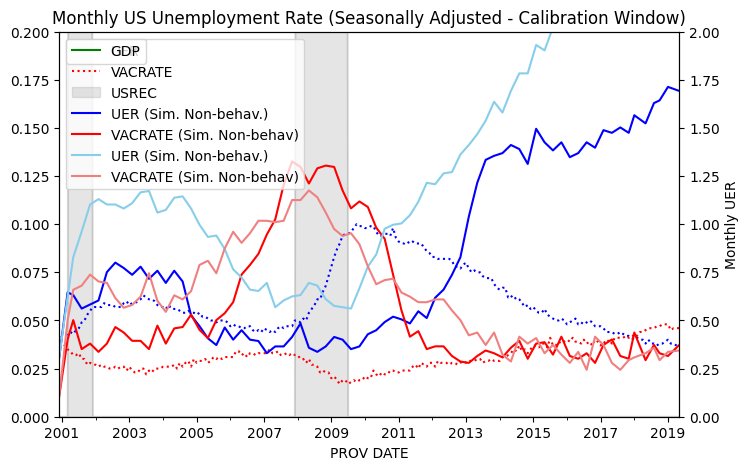

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


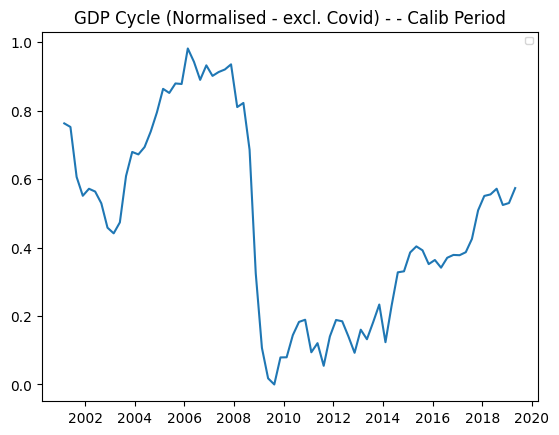

In [160]:
# Incorporating one set of simulated data
sim_data = pd.DataFrame(sim_record_f_all)
sim_data['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data))

sim_data_behav = pd.DataFrame(sim_record_t_all)
sim_data_behav['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data))
# sim_data_behav = pd.DataFrame(rec_behav)
# sim_data_behav['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data_behav), freq = "ME")
# sim_data_behav['FD_SIMUER'] = pd.Series(sim_data_behav['UER']).diff()
# sim_data_behav['FD_SIMVACRATE'] = pd.Series(sim_data_behav['VACRATE']).diff()


# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Non-behav.)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Non-behav)")
# Create a secondary y-axis
ax2 = ax.twinx()
ax2.plot(sim_data['PROV DATE'].iloc[1:].values, gdp_dat, color="green", linestyle="solid", label="GDP")
ax2.legend(loc='upper left')  # Ensure the legend appears
ax2.set_ylabel('GDP')

ax.set_xlim(calib_date[0], calib_date[1])
ax.set_ylim(0, 0.2)
ax2.set_ylim(0, 2)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted - Calibration Window)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
fig.canvas.draw()
plt.show()

plt.plot(sim_data['PROV DATE'].iloc[1:], gdp_dat)
plt.legend(fontsize=7)
plt.title("GDP Cycle (Normalised - excl. Covid) - - Calib Period")

plt.show()

In [161]:

# Summary values for one run 
sim_record_t = pd.DataFrame(np.transpose(np.hstack(sim_record_t_all)))
sim_record_t.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
sim_record_f = pd.DataFrame(np.transpose(np.hstack(sim_record_f_all)))
sim_record_f.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']

record1_t = sim_record_t[(sim_record_t['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index() #  
record1_f = sim_record_f[(sim_record_f['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index() #  & (sim_record_t['Time Step'] >= 80)

end_t = record1_t[(record1_t['Time Step'] == 280)]
end_f = record1_f[(record1_f['Time Step'] == 280)]

ue_vac_f = record1_f.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
#ue_vac_f = ue_vac_f[46:]

ue_vac_t = record1_t.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
#ue_vac_t = ue_vac_t[46:]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
#ue_vac_f = ue_vac_f[40:]
#ue_vac_t = ue_vac_t[40:]

ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
ax2.set_title("Behavioural")
ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0) 
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()

plt.plot()


# Incorporating one set of simulated data
ue_vac_f['PROV DATE'] = pd.date_range(start = calib_date[0], periods = len(gdp_dat)+1, freq = "ME")
ue_vac_f['FD_SIMUER'] = pd.Series(ue_vac_f['UE Rate']).diff()
ue_vac_f['FD_SIMVACRATE'] = pd.Series(ue_vac_f['Vac Rate']).diff()

ue_vac_t['PROV DATE'] = pd.date_range(start = calib_date[0], periods = len(gdp_dat)+1, freq = "ME")
ue_vac_t['FD_SIMUER'] = pd.Series(ue_vac_t['UE Rate']).diff()
ue_vac_t['FD_SIMVACRATE'] = pd.Series(ue_vac_t['Vac Rate']).diff()


# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
ue_vac_f.plot.line(ax = ax, x = 'PROV DATE', y = 'UE Rate', color = "blue", label = "UER (Sim. Non-behav.)")
ue_vac_f.plot.line(ax = ax, x = 'PROV DATE', y = 'Vac Rate', color = "red", label = "VACRATE (Sim. Non-behav)")
ue_vac_t.plot.line(ax = ax, x = 'PROV DATE', y = 'UE Rate', color = "skyblue", label = "UER (Sim. Behav.)")
ue_vac_t.plot.line(ax = ax, x = 'PROV DATE', y = 'Vac Rate', color = "lightcoral", label = "VACRATE (Sim. Behav.)")
plt.xlim(calib_date[0], calib_date[1])
plt.ylim(0, 1)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

plt.plot()

# ## Save results for import into model run

calib_params = [{"Parameter": "d_u", 'Value': d_u_hat},
                {"Parameter": "d_v", "Value": d_v_hat},
                {"Parameter": "gamma", "Value": gamma_hat},]
print(calib_params)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 8 elements

0.01022238313559328